In [ ]:
Individual evaluation report can be found in Model_Evaluation folder where each SLM
was evaluated with same set of prompts across 2 different similarity search algorithms
1. L2 (default for ChromaDB search) using k = 5 
2. Inner Product using similarity threshold of 0.5

The SLM response was manually evaluated using human evaluation via SQL queries on backend MySQL table. 
The prompts were converted to native MySQL queries and results were compared with SLM response. 


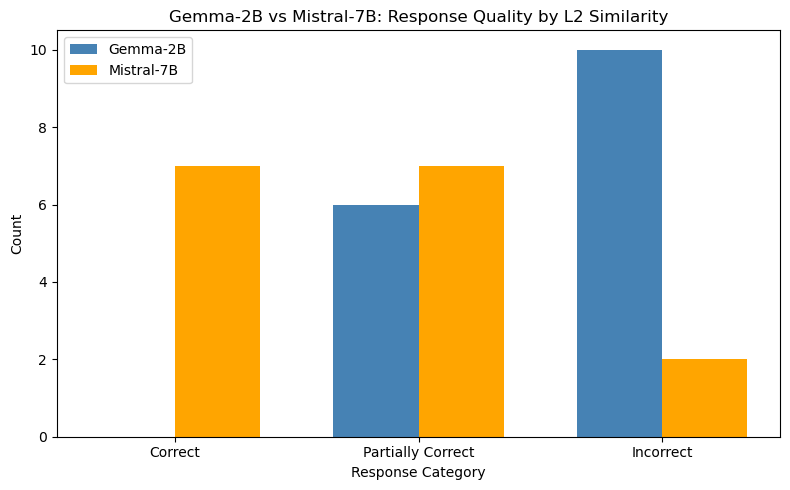

Gemma-2B Accuracy: 0.0
Mistral-7B Accuracy: 0.4375


In [3]:


#SLM comparison (Gemma-2b v/s Mistral-7B) across prompts. The list below represents 
#correct, partially correct, incorrect response count using L2 similarity search

import pandas as pd
import matplotlib.pyplot as plt

# Define the data
categories = ['Correct', 'Partially Correct', 'Incorrect']
mistral_7b = [7, 7, 2]
gemma_2b = [0, 6, 10]

# Create a DataFrame
df = pd.DataFrame({
    'Category': categories,
    'Gemma-2B': gemma_2b,
    'Mistral-7B': mistral_7b
})
# Set the figure size for better readability
plt.figure(figsize=(8, 5))

# Create side-by-side bar plot
bar_width = 0.35
index = range(len(categories))

plt.bar(index, df['Gemma-2B'], bar_width, label='Gemma-2B', color='steelblue')
plt.bar([i + bar_width for i in index], df['Mistral-7B'], bar_width, label='Mistral-7B', color='orange')

plt.xlabel('Response Category')
plt.ylabel('Count')
plt.title('Gemma-2B vs Mistral-7B: Response Quality by L2 Similarity')
plt.xticks([i + bar_width / 2 for i in index], categories)
plt.legend()
plt.tight_layout()
plt.show()
# Calculate accuracy metrics
total_gemma = sum(gemma_2b)
total_mistral = sum(mistral_7b)

acc_gemma = gemma_2b[0] / total_gemma
acc_mistral = mistral_7b[0] / total_mistral

print("Gemma-2B Accuracy:", acc_gemma)
print("Mistral-7B Accuracy:", acc_mistral)

# Output:
# Gemma-2B Accuracy: 0.412
# Mistral-7B Accuracy: 0.0




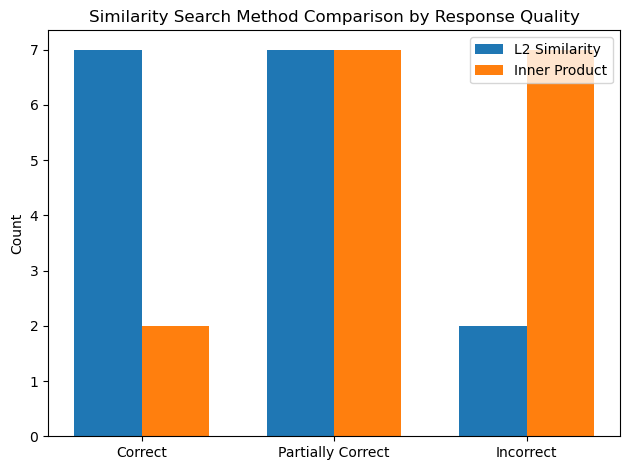

In [4]:
#Based on higher accuracy of Mistral-7B it was selected as the choice of SLM
#for further evaluation. Next a comparison was ran across prompts using inner
#product for similarity search with threshold of 0.55


#same as before
l2_similarity_search = [7,7,2]
inner_product = [2,7,7]
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Correct', 'Partially Correct', 'Incorrect']
l2_similarity_search = [7, 7, 2]
inner_product = [2, 7, 7]

# Create DataFrame
df = pd.DataFrame({
    'Category': categories,
    'L2 Similarity': l2_similarity_search,
    'Inner Product': inner_product
})

# Positions for bar groups
x = np.arange(len(categories))
bar_width = 0.35

# Plotting
fig, ax = plt.subplots()
bars1 = ax.bar(x - bar_width/2, df['L2 Similarity'], width=bar_width, label='L2 Similarity')
bars2 = ax.bar(x + bar_width/2, df['Inner Product'], width=bar_width, label='Inner Product')

# Labels and formatting
ax.set_ylabel('Count')
ax.set_title('Similarity Search Method Comparison by Response Quality')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()



L2 similarity search demonstrates superior performance in distinguishing correct answers,
outperforming inner product similarity — particularly in yielding a higher proportion of fully correct 
results with fewer incorrect classifications when applied to Mistral-7B. The next step will be to fine-tune
the transformer model using internal application knowledge, aiming to further improve response accuracy in 
conjunction with L2 similarity search.
This targeted tuning should enhance the model’s effectiveness for downstream retrieval and evaluation tasks.